<a href="https://www.kaggle.com/code/faisalalbasu/spectrogram-windows-test?scriptVersionId=137480549" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [111]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [112]:
# small sampled data
!wget 'https://raw.githubusercontent.com/albas99/Fourier-Transform/master/sample%20analysis.csv'

--2023-07-21 14:18:01--  https://raw.githubusercontent.com/albas99/Fourier-Transform/master/sample%20analysis.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17946 (18K) [text/plain]
Saving to: ‘sample analysis.csv.1’

sample analysis.csv 100%[===================>]  17.53K  --.-KB/s    in 0s      

2023-07-21 14:18:02 (60.4 MB/s) - ‘sample analysis.csv.1’ saved [17946/17946]



In [113]:
# full data for maximimum signals
!wget 'https://raw.githubusercontent.com/albas99/Fourier-Transform/master/maximum.csv'

--2023-07-21 14:18:03--  https://raw.githubusercontent.com/albas99/Fourier-Transform/master/maximum.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2175038 (2.1M) [text/plain]
Saving to: ‘maximum.csv.1’

maximum.csv.1       100%[===================>]   2.07M  --.-KB/s    in 0.02s   

2023-07-21 14:18:03 (86.8 MB/s) - ‘maximum.csv.1’ saved [2175038/2175038]



In [114]:
max_erg = pd.read_csv('/kaggle/working/maximum.csv', sep = ',', index_col = 'Time,ms')
max_erg.head()

,3,3.1,5,6,6.1,6.2,7,10,11,15,...,1880,1931,1961,1961.1,1962,1962.1,1963,1963.1,1964,1964.1
"Time,ms",,,,,,,,,,,,,,,,,,,,,
0.0,0.000004,-2.35,0.000013,-10.8,1.150000e-06,0.000003,-3.466499,-8.67,1.320000e-06,-3.10,...,0.000025,0.000029,-2.076184,-7.590125,0.000002,0.000002,0.000022,0.000019,0.000017,0.00002
0.5,0.000004,-2.47,0.000012,-11.1,9.600000e-07,0.000003,-3.523260,-9.02,1.120000e-06,-3.45,...,0.000025,0.000029,-2.106670,-7.468806,0.000002,0.000002,0.000022,0.000019,0.000017,0.00002
1.0,0.000004,-2.63,0.000012,-11.5,7.460000e-07,0.000002,-3.602958,-9.39,9.050000e-07,-3.83,...,0.000025,0.000028,-2.131098,-7.339658,0.000002,0.000002,0.000022,0.000019,0.000017,0.00002
1.5,0.000004,-2.80,0.000012,-11.9,5.060000e-07,0.000002,-3.705310,-9.79,6.810000e-07,-4.25,...,0.000025,0.000028,-2.149734,-7.204155,0.000002,0.000002,0.000022,0.000019,0.000016,0.00002
2.0,0.000003,-3.01,0.000012,-12.4,2.440000e-07,0.000001,-3.829635,-10.20,4.460000e-07,-4.70,...,0.000025,0.000027,-2.162955,-7.063886,0.000002,0.000002,0.000022,0.000019,0.000016,0.00002


In [115]:
data = pd.read_csv('/kaggle/working/sample analysis.csv', sep = ',', index_col='Time,ms')
data

,3,5,6,6.1,6.2,15,17,17.1
"Time,ms",,,,,,,,
0.0,-2.351363,0.000013,-10.800000,1.150000e-06,0.000003,-3.100000,1.470000e-06,0.000005
0.5,-2.473562,0.000012,-11.100000,9.600000e-07,0.000003,-3.450000,1.310000e-06,0.000005
1.0,-2.625094,0.000012,-11.500000,7.460000e-07,0.000002,-3.830000,1.130000e-06,0.000004
1.5,-2.804676,0.000012,-11.900000,5.060000e-07,0.000002,-4.250000,9.300000e-07,0.000004
2.0,-3.010519,0.000012,-12.400000,2.440000e-07,0.000001,-4.700000,7.250000e-07,0.000004
...,...,...,...,...,...,...,...,...
98.0,-2.117023,-0.000012,24.090590,3.810000e-06,0.000004,-8.207112,-8.300000e-06,-0.000011
98.5,-2.444991,-0.000013,23.955892,4.010000e-06,0.000004,-8.046144,-7.690000e-06,-0.000011
99.0,-2.729824,-0.000014,23.885146,4.220000e-06,0.000004,-7.833394,-7.080000e-06,-0.000011


In [116]:
NFFTS = [128, 64, 32, 16, 8, 4]
overlaps = [64, 32, 16, 8, 4, 2]
windows = ['hann', 'hamming', 'blackman', 'tukey', 'boxcar', 'bartlett', 'blackmanharris']

In [117]:
def plot_spectrogram(sig: str, nfft, noverlap, colormap):
    time_step = 0.005 # in seconds
    sample_freq = 1 / time_step
    sig = np.array(data[sig])
    
    assert sig.ndim  == 1
    assert nfft <= len(sig)
    
#     window = np.blackman(nfft)
    window = signal.get_window('taylor', nfft)
    
    Sxx, freqs, bins, im = plt.specgram(sig, Fs = sample_freq, NFFT = nfft, noverlap = noverlap, cmap = colormap, window = window)
    plt.colorbar().set_label('Power')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()
    return Sxx

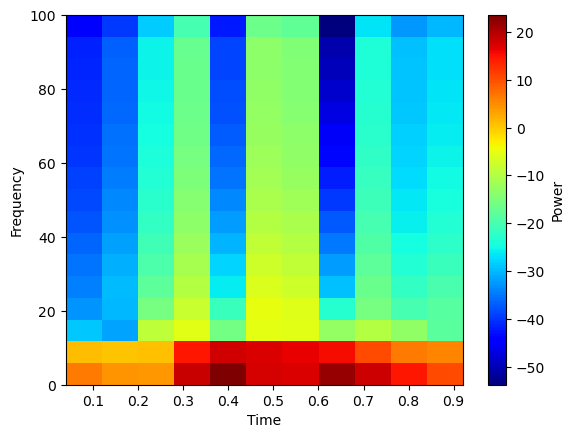

array([[4.33709244e+00, 2.65861246e+00, 2.54532003e+00, 7.06965972e+01,
        2.26604003e+02, 5.74547053e+01, 5.31289395e+01, 1.49714825e+02,
        6.87973490e+01, 2.93466028e+01, 1.10826119e+01],
       [1.30984961e+00, 1.09997718e+00, 1.18784868e+00, 2.87577914e+01,
        6.33634821e+01, 5.28113567e+01, 4.49963858e+01, 3.61094701e+01,
        1.13158017e+01, 4.40829540e+00, 3.71408078e+00],
       [1.28769908e-03, 7.18429767e-04, 1.24344319e-01, 2.77085104e-01,
        2.67676909e-02, 2.91344655e-01, 2.76924762e-01, 5.24926306e-02,
        1.04048872e-01, 4.84404912e-02, 1.52123437e-02],
       [5.44651682e-04, 9.69520204e-04, 2.75514334e-02, 1.55087308e-01,
        7.60745493e-03, 3.21570494e-01, 2.56313353e-01, 4.75062164e-03,
        2.80797209e-02, 9.73907960e-03, 1.39891396e-02],
       [3.81652067e-04, 1.04953427e-03, 1.60177237e-02, 1.06634191e-01,
        2.42627726e-03, 2.40596151e-01, 1.85494627e-01, 1.09810483e-03,
        2.14644970e-02, 6.23839653e-03, 1.03974620e-

In [118]:
plot_spectrogram('3', 32, 16, 'jet')

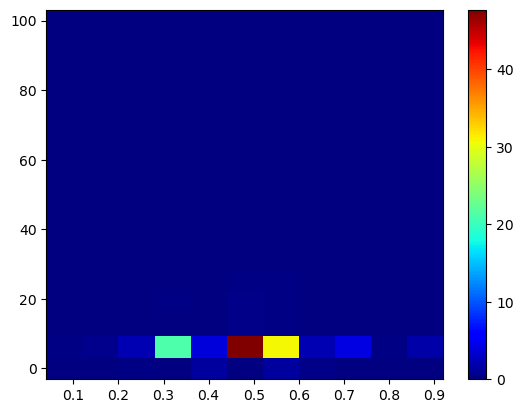

In [119]:
def compute_spectrogram(sig, nperseg, noverlap, window):
    time_step = 0.005
    sample_freq = 1 / time_step
    sig = np.array(data[sig])
    freqs, times, Sxx = signal.spectrogram(sig, fs = sample_freq, nperseg = nperseg, noverlap = noverlap, window = window)
    
    return freqs, times, Sxx

freqs, times, Sxx = compute_spectrogram('3', nperseg = 32, noverlap = 16, window = 'tukey')

plt.pcolormesh(times, freqs, Sxx, cmap = 'jet')
plt.colorbar()

In [120]:
def get_features(sig, nperseg, noverlap, window):
    freqs, times, Sxx = compute_spectrogram(sig, nperseg, noverlap, window)
    spectrum = Sxx.flatten()
    bmin = np.min(spectrum)
    bmedian = np.median(spectrum)
    bmax = np.max(spectrum)
    bmean = np.mean(spectrum)
    
    return bmin, bmedian, bmax, bmean

In [121]:
# def get_parameters():
#     size, overlap, name = None, None, None
#     for n in NFFTS:
#         size = n
#     for o in overlaps:
#         overlap = o
#     for w in windows:
#         name = w
#     # use random.choice instead of loop
#     # then loop through the signals instead
#     return size, overlap, name

# print(get_parameters())

In [122]:
import random
def get_parameters():
    window_type = random.choice(windows)
    
    window_size = random.choice(NFFTS)

    overlap = random.choice(overlaps)
    
    while overlap >= window_size:
        overlap = random.choice(overlaps)

#     if overlap >= window_size:
#         window_size = random.choice(NFFTS)
#         overlap = random.choice(overlaps)
#     else:
#         return window_size, overlap, window_type
#         print(window_size, overlap, window_type)


    
    return window_size, overlap, window_type

#     print(window_size, overlap, window_type)
    
# get_parameters()

In [123]:
dfeatures = pd.DataFrame(columns = ['params', 'bmin', 'bmedian', 'bmax', 'bmean'])
dfeatures

,params,bmin,bmedian,bmax,bmean


In [124]:
for col in data.columns:
    window_size, overlap, window_type = get_parameters()
    bmin, bmedian, bmax, bmean = get_features(str(col), window_size, overlap, window_type)
    new_dict = {'params': f'{window_type}{window_size}{overlap}', 'bmin': bmin, 'bmedian': bmedian, 'bmax': bmax, 'bmean': bmean}
    new_features = pd.DataFrame(data = new_dict, index = range(0, len(new_dict)))
    dfeatures = pd.concat([dfeatures, new_features], ignore_index = True)
    
# dfeatures

In [125]:
len(data.columns)

8

In [126]:
dfeatures

,params,bmin,bmedian,bmax,bmean
0,blackmanharris642,1.100572e-10,1.955097e-09,7.723608e+01,1.427965e+00
1,blackmanharris642,1.100572e-10,1.955097e-09,7.723608e+01,1.427965e+00
2,blackmanharris642,1.100572e-10,1.955097e-09,7.723608e+01,1.427965e+00
3,blackmanharris642,1.100572e-10,1.955097e-09,7.723608e+01,1.427965e+00
4,blackmanharris642,1.100572e-10,1.955097e-09,7.723608e+01,1.427965e+00
5,boxcar42,0.000000e+00,6.301250e-16,1.007349e-13,7.721968e-15
6,boxcar42,0.000000e+00,6.301250e-16,1.007349e-13,7.721968e-15
7,boxcar42,0.000000e+00,6.301250e-16,1.007349e-13,7.721968e-15
8,boxcar42,0.000000e+00,6.301250e-16,1.007349e-13,7.721968e-15
9,boxcar42,0.000000e+00,6.301250e-16,1.007349e-13,7.721968e-15


In [127]:
dfeatures.drop_duplicates()

,params,bmin,bmedian,bmax,bmean
0,blackmanharris642,1.100572e-10,1.955097e-09,7.723608e+01,1.427965e+00
5,boxcar42,0.000000e+00,6.301250e-16,1.007349e-13,7.721968e-15
10,hamming42,1.903479e-10,1.816610e-03,5.306706e-01,3.413002e-02
15,bartlett644,3.866215e-21,4.517146e-17,1.444064e-10,1.760568e-12
20,tukey162,1.147871e-21,1.148611e-15,8.347936e-12,2.151699e-13
25,bartlett84,7.794471e-08,2.198602e-04,1.015202e+00,3.448185e-02
30,hann6416,1.350630e-21,5.867704e-18,4.901262e-11,1.009440e-12
35,blackman648,1.279984e-21,5.789602e-18,5.495754e-11,9.763024e-13
